# BBC News Classification
Here, we seek to classify BBC articles in one of 5 categories:
1. Business
2. Entertainment
3. Politics
4. Sport
5. Tech

To do this, we will utilize Non-negative Matrix Factorization to extract common features from words, which are encoded using sklearn's TF-IDF vectorizer. From here, we compare the approach to standard supervised learning algorithms (RandomForest and AdaBoost). The overall, data-analysis process is described below:
1. **Data Ingestion, Inspection, Description, and Visualization:** to search for missing values or other inconsistencies and gain a better understanding of the data at hand
2. **Data Processing:** Vectorize data into a TF-IDF matrix
3. **Model Building:** Creating and training of NMF, RandomForest, and AdaBoost models.
4. **Model Submission:** Testing of model accuracy via Kaggle submission for each model
5. **Model Analysis and Comparsion:** Analysis of scores and NMF versus supervised learning algorithms

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
!pip install klib

In [3]:
# ML Models
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Inspection
import klib

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Classification metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# etc...
from itertools import permutations

In [4]:
class Data:
    def __init__(self, df_train, df_test):
        """Load data as a Pandas DataFrame in preparation for model building, analysis."""
        self.df_train = df_train
        self.df_test = df_test
        
        # Capture the potential categories
        self.categories = pd.unique(df_train["Category"])
        self.n_categories = len(self.categories)
        
        # Extract the training labels
        self.train_y = df_train["Category"]
        
        # Vectorize the document text to create our training and testing features
        self.vectorize()
        
        # Create a dictionary to hold our fitted models
        self.models = {}
    
    def __str__(self):
        return f"""\
BBC News Data:
├── Categories:         {self.categories}
├── # Categories:       {self.n_categories}
├── Train Observations: {len(self.df_train)}
└── Test Observations:  {len(self.df_test)}

Train TF-IDF Matrix: {self.train_x.shape}
Test TF-IDF Matrix:  {self.test_x.shape}

Fitted Models:
{self.models}\
"""
    
    def vectorize(self):
        """Vectorize the data into an TF-IDF matrix."""
        vectorizer = TfidfVectorizer(min_df=50, stop_words="english")
        
        self.train_x = vectorizer.fit_transform(self.df_train["Text"])
        self.test_x = vectorizer.transform(self.df_test["Text"])
        self.feature_names = vectorizer.get_feature_names_out()
    
    def fit_nmf(self, beta_loss="frobenius"):
        """Fit the vectorized training data to a Non-negative Matrix Factorization (NMF) model."""
        model = NMF(n_components=self.n_categories, solver="mu", beta_loss=beta_loss)                    
        model.fit(self.train_x)
        
        # Add the fitted model to our models dictionary
        self.models[f"nmf-{beta_loss}"] = model
    
    def predict_nmf(self, tfidf=None, beta_loss="frobenius"):
        """Predict from the fitted NMF model and generate cluster indices for each observation.
        
        Parameters
        ----------
        tfidf: Array-like or None, default=None
            The TF-IDF matrix transformed from the training data. If None, it will utilize the
            training data.
        
        Returns
        -------
        predictions: np.ndarray
            A 1D numpy array containing the cluster index predictions
        """
        assert f"nmf-{beta_loss}" in self.models.keys(), "Must fit an NMF model prior to making predictions."
        model = self.models[f"nmf-{beta_loss}"]
        
        if tfidf is None:
            tfidf = self.train_x
        
        # Transform the fitted NMF matrix to obtain the features matrix
        model_features = model.transform(tfidf)
        model_components = pd.DataFrame(model.components_, columns=self.feature_names)
        
        # Make predictions from the model
        predictions = np.argmax(model_features, axis=1)
        return predictions
                
    def fit_random_forest(self):
        """Fit the vectorized training data to a random forest model."""
        model = RandomForestClassifier(n_estimators=250)
        model.fit(self.train_x, self.train_y)
        
        # Add the fitted model to our models dictionary
        self.models["rf"] = model
    
    def predict_random_forest(self, tfidf=None):
        """Predict from the fitted random forest model. If tfidf is None, the training
        observations are utilized instead."""
        assert "rf" in self.models.keys(), "Must fit a random forest model prior to making predictions."
        model = self.models["rf"]
        
        if tfidf is None:
            tfidf = self.train_x
        
        predictions = model.predict(tfidf)
        return predictions
            
    def fit_ada_boost(self):
        """Fit the vectorized training data to a AdaBoost model."""
        model = AdaBoostClassifier(n_estimators=250)
        model.fit(self.train_x, self.train_y)
        
        # Add the fitted model to our models dictionary
        self.models["ada"] = model
    
    def predict_ada_boost(self, tfidf=None):
        """Predict from the fitted ada boost model. If tfidf is None, the training
        observations are utilized instead."""
        assert "ada" in self.models.keys(), "Must fit an ada boost model prior to making predictions."
        model = self.models["ada"]
        
        if tfidf is None:
            tfidf = self.train_x
        
        predictions = model.predict(tfidf)
        return predictions
    
    
def labels_to_indices(indices_pred, labels_true, labels):
    """Map index predictions to the most accurate labels based on the underlying truth
    
    Parameters
    ----------
    indices_pred: np.ndarray
        1D array of cluster index predictions
    labels_true: iterable
        Iterable containing the true labels
    labels: iterable
        The potential labels
        
    Returns
    -------
    best_mapping: dict
        The mapping from labels to indices that provides the most accurate results
    """
    n_labels = len(labels)# To avoid divergence in itakura-saito, we must add small values to our training data

    n = len(indices_pred)
    
    # Store a best accuracy and permutation mapping to later return
    best_accuracy = 0
    best_mapping = None

    # Create different permutations of the potential indices
    for perm in permutations(range(n_labels)):
        # Generate the mapping {label} -> {index}
        mapping = {label: perm[i] for i, label in enumerate(labels)}

        # Iterate through the truth and apply the mapping
        label_true_inds = np.array([mapping[label] for label in labels_true])

        # Compute the accuracy
        accuracy = np.sum(label_true_inds == indices_pred) / n

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping

    return best_mapping


def plot_confusion_matrix(confusion_matrix, labels):
    """Plots a confusion matrix given the matrix and labels."""
    fig, ax = plt.subplots(figsize=(13, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        linewidths=0.5,
        ax=ax,
        xticklabels=labels,
        yticklabels=labels
    )

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Truth")
    
    return (fig, ax)

## 1. Data Ingestion, Inspection, Description, and Visualization
We will begin by loading in the data, and inspecting it for any missing values. Since it is text data, it is hard to visualize. To clean the data, we first gain a general understanding of the dataframes by displaying them. Using the `missingval_plot` function from `klib`, we can investigate whether any missing values exist. Lastly, to provide a visualization element, we create a bar plot containing the frequencies of each category in the training data.

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


No missing values found in the dataset.
No missing values found in the dataset.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


<BarContainer object of 5 artists>

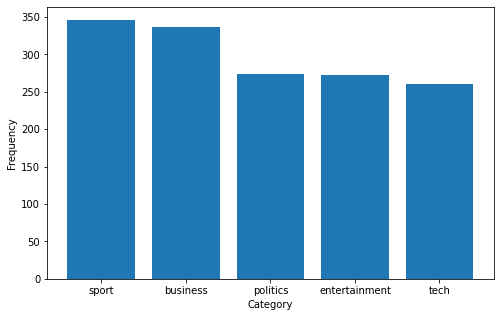

In [5]:
# Obtain file paths to data
fname_train = r"/kaggle/input/learn-ai-bbc/BBC News Train.csv"
fname_test = r"/kaggle/input/learn-ai-bbc/BBC News Test.csv"
fname_sample = r"/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv"

# Load data as DataFrames
df_train = pd.read_csv(fname_train)
df_test = pd.read_csv(fname_test)
df_sample = pd.read_csv(fname_sample)

display(df_train)
display(df_test)
display(df_sample)

# Search for missing values in the training and testing set
klib.missingval_plot(df_train)
klib.missingval_plot(df_test)

# Inspect the training data
df_train.info()

# Examine the distribution of different categoies
counts = df_train["Category"].value_counts()
categories = counts.index
n_categories = len(categories)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")
ax.bar(
    x=range(n_categories),
    height=counts.to_list(),
    tick_label=counts.index
)

## 2. Data Processing
By initializing our Data() class, we will be able to vectorize the text into a TF-IDF matrix and prepare it for model building and training. TF-IDF is an acronym for *Term Frequency - Inverse Document Frequency*. A TF-IDF matrix allows us to determine how important each given word (feature) is in a set of documents. We can compute the term frequency as follows:

$$
t_f(w, d) = \log(1 + f(w, d)),
$$

where $f(w, d))$ represents the frequency of a given word, $w$, in a document, $d$. The inverse document frequency is then simply

$$
id_f(w, D) = \log\left(\frac{N}{f(w, D)}\right),
$$

where $f(w, D)$ is the frequency of a given word, $w$, in the entire set of documents, $D$, and $N$ is the total number of documents. It can be easily seen that as as the document frequency increases, the inverse document frequency will decrease. Lastly, we can combine these principle to compute the term frequency-inverse document frequency as the product between the term frequency and inverse document frequency:

$$
tfid_f(w, d, D) = t_f(w,d) \cdot id_f(w, D)
$$

This estimates the *importance* of individual words (features). To prevent unecessary words that appear in all documents, we set a minimum word frequency threshold of 50 before it can be factored into the computation

In [6]:
# Create our Data() class to ingest process our data and create a TF-IDF matrix for model fitting
data = Data(df_train, df_test)
print(data)

BBC News Data:
├── Categories:         ['business' 'tech' 'politics' 'sport' 'entertainment']
├── # Categories:       5
├── Train Observations: 1490
└── Test Observations:  735

Train TF-IDF Matrix: (1490, 937)
Test TF-IDF Matrix:  (735, 937)

Fitted Models:
{}


## 3. Model Building
As mentioned previously, we will build 3 models: a non-negative matrix factorization model (NMF), a random forest model, and a ada boost model. The supervised model approaches will allow us to compare the effectiveness of a relatively unsupervised method (NMF). In NMF, we aim to approximate the input matrix, which is created by our TF-IDF vectorizer, as the product of 2 smaller matrices. That is, $\mathbf{V} \approx \mathbf{WH}$. The feature matrix, $\mathbf{W}$, will approximate the relative importance of each feature in each row. Thus, when we make predictions, we simply assign the observation to the cluster with the maximial feature importance. The rows of the coefficient matrix, $\mathbf{H}$ correspond to each document, where the columns correspond to the importance of a given feature (word). 

Because of this, we *train* the model with the TF-IDF matrix created from the training data. So the dimensionality and features of the testing and training data are consistent, we will create the TF-IDF from the testing data by transforming the training data's TF-IDF matrix. As such, testing the NMF will only utilize words seen in both the training and testing data since our matrices are of fixed dimensions.

NMF comes with multiple loss functions, `frobenius`, `kullback-leibler`, and `itakura-saito`. Since `itakura-saito` does not work with a negative beta-loss, we are unable to work with the loss function on the data. We will experiment with altering the other 2 and see which give the best performance.

### 3.1. Non-negative Matrix Factorization Model

#### 3.1.1 Frobenius Loss

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


{4: 'business', 2: 'tech', 0: 'politics', 1: 'sport', 3: 'entertainment'}
               precision    recall  f1-score   support

     business       0.95      0.86      0.90       336
entertainment       0.95      0.63      0.76       273
     politics       0.78      0.97      0.86       274
        sport       0.87      0.97      0.91       346
         tech       0.84      0.89      0.87       261

     accuracy                           0.87      1490
    macro avg       0.88      0.86      0.86      1490
 weighted avg       0.88      0.87      0.86      1490



(<Figure size 936x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted', ylabel='Truth'>)

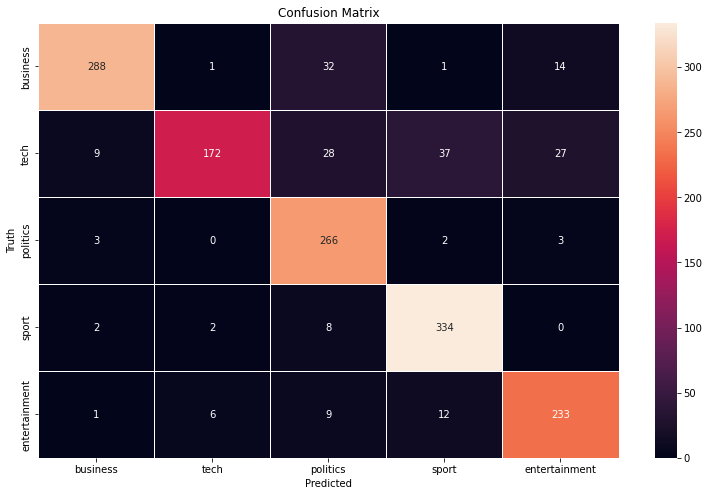

In [7]:
# Fit the NMF model 
data.fit_nmf()

# Obtain the fitted training examples
nmf_fitted = data.predict_nmf()

# Map the fitted values to labels
mapping = labels_to_indices(nmf_fitted, data.train_y, labels=data.categories)# To avoid divergence in itakura-saito, we must add small values to our training data

mapping_r = {v:k for k, v in mapping.items()}
print(mapping_r)

# Apply the mapping to our fitted data
nmf_fitted = [mapping_r[a] for a in nmf_fitted]

# Create a classification report
print(classification_report(data.train_y, nmf_fitted))

# We'll also create a confusion matrix
cm_nmf = confusion_matrix(data.train_y, nmf_fitted)
plot_confusion_matrix(cm_nmf, data.categories)



#### 3.1.2 Kullback-Leibler Loss

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


               precision    recall  f1-score   support

     business       0.96      0.85      0.90       336
entertainment       0.97      0.85      0.91       273
     politics       0.76      0.97      0.85       274
        sport       0.94      0.95      0.94       346
         tech       0.90      0.89      0.89       261

     accuracy                           0.90      1490
    macro avg       0.91      0.90      0.90      1490
 weighted avg       0.91      0.90      0.90      1490



(<Figure size 936x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted', ylabel='Truth'>)

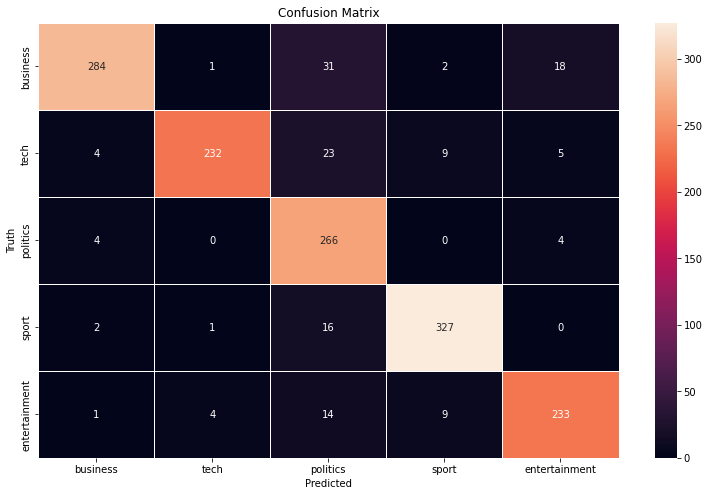

In [8]:
# Fit the NMF model 
data.fit_nmf(beta_loss="kullback-leibler")

# Obtain the fitted training examples
nmf_fitted_kl = data.predict_nmf(beta_loss="kullback-leibler")

# Map the fitted values to labels
mapping_kl = labels_to_indices(nmf_fitted_kl, data.train_y, labels=data.categories)
mapping_kl_r = {v:k for k, v in mapping_kl.items()}

# Apply the mapping to our fitted data
nmf_fitted_kl = [mapping_kl_r[a] for a in nmf_fitted_kl]

# Create a classification report
print(classification_report(data.train_y, nmf_fitted_kl))

# We'll also create a confusion matrix
cm_nmf_kl = confusion_matrix(data.train_y, nmf_fitted_kl)
plot_confusion_matrix(cm_nmf_kl, data.categories)

### 3.2. Random Forest Model

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       336
entertainment       1.00      1.00      1.00       273
     politics       1.00      1.00      1.00       274
        sport       1.00      1.00      1.00       346
         tech       1.00      1.00      1.00       261

     accuracy                           1.00      1490
    macro avg       1.00      1.00      1.00      1490
 weighted avg       1.00      1.00      1.00      1490



(<Figure size 936x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted', ylabel='Truth'>)

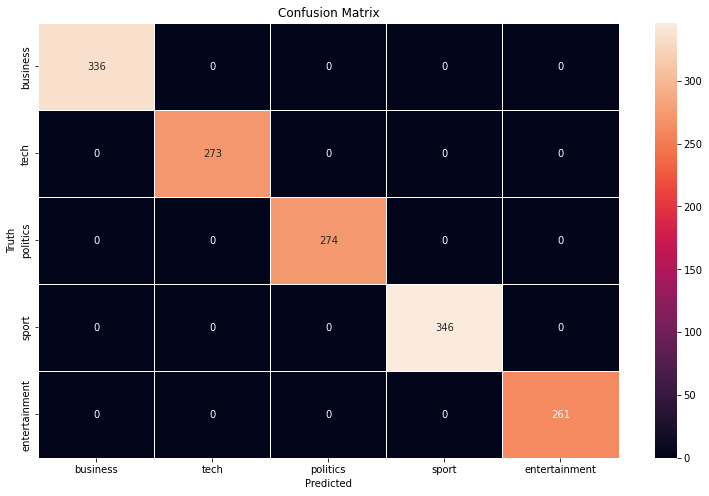

In [9]:
# Fit the random forest model
data.fit_random_forest()
rf_fitted = data.predict_random_forest()

# Create a classification report
print(classification_report(data.train_y, rf_fitted))

# We'll also create a confusion matrix
cm_rf = confusion_matrix(data.train_y, rf_fitted)
plot_confusion_matrix(cm_rf, data.categories)

### 3.3. Ada Boost Model

               precision    recall  f1-score   support

     business       0.70      0.93      0.80       336
entertainment       0.96      0.87      0.91       273
     politics       0.99      0.74      0.84       274
        sport       0.90      0.95      0.93       346
         tech       0.97      0.85      0.91       261

     accuracy                           0.88      1490
    macro avg       0.91      0.87      0.88      1490
 weighted avg       0.90      0.88      0.88      1490



(<Figure size 936x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted', ylabel='Truth'>)

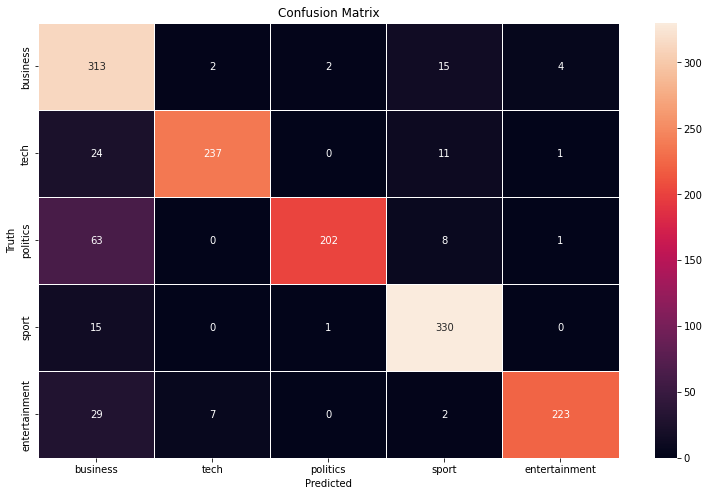

In [10]:
# Fit the ada boost model
data.fit_ada_boost()
ada_fitted = data.predict_ada_boost()

# Create a classification report
print(classification_report(data.train_y, ada_fitted))

# We'll also create a confusion matrix
cm_ada = confusion_matrix(data.train_y, ada_fitted)
plot_confusion_matrix(cm_ada, data.categories)

## 4. Model Submission

In [11]:
# View our fitted models
print(data)

BBC News Data:
├── Categories:         ['business' 'tech' 'politics' 'sport' 'entertainment']
├── # Categories:       5
├── Train Observations: 1490
└── Test Observations:  735

Train TF-IDF Matrix: (1490, 937)
Test TF-IDF Matrix:  (735, 937)

Fitted Models:
{'nmf-frobenius': NMF(n_components=5, solver='mu'), 'nmf-kullback-leibler': NMF(beta_loss='kullback-leibler', n_components=5, solver='mu'), 'rf': RandomForestClassifier(n_estimators=250), 'ada': AdaBoostClassifier(n_estimators=250)}


In [12]:
# Generate predictions for NMF, random forest, and adaboost
nmf_predicted = data.predict_nmf(data.test_x)
nmf_predicted = [mapping_r[a] for a in nmf_predicted]

nmf_kl_predicted = data.predict_nmf(data.test_x, beta_loss="kullback-leibler")
nmf_kl_predicted = [mapping_kl_r[a] for a in nmf_kl_predicted]

rf_predicted = data.predict_random_forest(data.test_x)

ada_predicted = data.predict_ada_boost(data.test_x)

# Create submission dataframes for each model
df_submission = df_test.drop(labels="Text", axis=1)

# df_submission["Category"] = nmf_predicted
df_submission["Category"] = nmf_kl_predicted
# df_submission["Category"] = rf_predicted
# df_submission["Category"] = ada_predicted

df_submission.to_csv("submission.csv", index=False)

# Ensure the files were created
print(os.listdir())

['submission.csv', '__notebook__.ipynb']


## 5. Model Analysis and Comparsion
Upon submitting each model, we find the testing accuracies for the corresponding models:

| Model         | Accuracy |
|---------------|----------|
| NMF (Frob)    | 87.76    |
| NMF (KL)      | 90.61    |
| Random Forest | 95.51    |
| Ada Boost     | 81.36    |

Overall, the random forest performs best, but the NMF models still performs decently well. The NMF with a Frobenius loss has approximately 87.76% accuracy, while the kullback-leibler loss has slightly higher accuracy at 90.61%. Ada boost, surprisingly, does not perform particularly well. Perhaps this is due to the high-dimensional space. The ensemble process of random forest overcomes this much better than ada boost may. The NMF likely performs worse the random forest due to the fact the NMF is an unsupervised task and we must rely purely on grouping similar data together.